In [1]:
import numpy as np 
from gcs import path_handler as ph 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os 

In [2]:
dark=False
results_path=ph.paths['simulations'] + "/ImpactGeometry/pouliasis2017pii-GCNBody/Pal5"+"/AllImpactGeometryByHandAndEye.csv"

if dark==True:
    plt.style.use('dark_background')
    outname="histogram_impact_time_dark.png"
else:
    outname="histogram_impact_time.png"

In [3]:
results = pd.read_csv(results_path)
withgap=results[results['gap_flag']]

In [4]:
unique_suspects = np.unique(withgap['suspect'])
per_suspect = {}
for i,suspect in enumerate(unique_suspects):
    per_suspect[suspect]=np.array(withgap[withgap['suspect']==suspect]['T'])

nbins = 20
bin_edges = np.linspace(-5,0,nbins+1)
centers = (bin_edges[1:] + bin_edges[:-1]) / 2

histograms = [ ]
for i in range(len(unique_suspects)):
    hist, bins = np.histogram(per_suspect[unique_suspects[i]], bins=bin_edges)
    histograms.append(hist)
histograms = np.array(histograms)

# Sort and stack histograms
# sorted_indices = np.argsort(-histograms, axis=0)  # Sort in descending order
sorted_histograms = np.zeros_like(histograms)
for i in range(nbins):
    sorted_histograms[:, i] = histograms[:, i]

cmap = cm.get_cmap('tab20', len(unique_suspects))  # 'tab20' is a colormap with 20 distinct colors


/tmp/ipykernel_1155086/4085496483.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_suspects))  # 'tab20' is a colormap with 20 distinct colors


In [5]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [6]:
text_properties = dict(
    ha='left', 
    va='bottom', 
    fontsize=8, 
    rotation=50)

axis_properties = dict(
    xlabel='Time of impact [s kpc / km]', 
    ylabel='Number of impacts', )

axis1_properties = dict(
    yticks= [40, 42, 44])


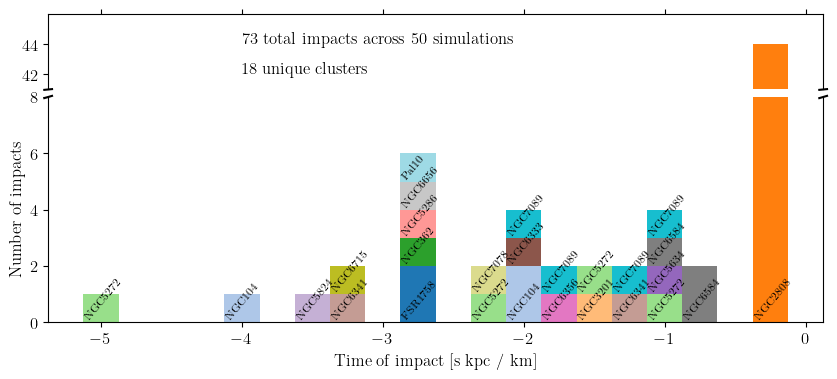

In [7]:

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10, 4),sharex=True,gridspec_kw={'height_ratios': [1, 3], 'hspace': 0.05})
dy=1.5
dx = bin_edges[1]-bin_edges[0]
# do it one bin at a time,
for j in range(nbins):
    present_suspects=np.where(histograms[:,j]>0)[0]
    sort_indexes =np.argsort(histograms[present_suspects,j])[::-1]
    for i in range(len(present_suspects)):
        ax2.bar(bin_edges[j], histograms[present_suspects[sort_indexes[i]], j], width=dx, bottom=np.sum(histograms[present_suspects[sort_indexes[:i]], j]), color=cmap(present_suspects[i]), label=unique_suspects[present_suspects[sort_indexes[i]]])
        ax1.bar(bin_edges[j], histograms[present_suspects[sort_indexes[i]], j], width=dx, bottom=np.sum(histograms[present_suspects[sort_indexes[:i]], j]), color=cmap(present_suspects[i]), label=unique_suspects[present_suspects[sort_indexes[i]]])
        
    bottom = np.sum(histograms[present_suspects[sort_indexes[:]], j])

    for i in range(len(present_suspects)):
        ypos = bottom + i*dy
        ypos = np.sum(histograms[present_suspects[sort_indexes[:i]], j])
        ax2.text(bin_edges[j] - dx/2  , ypos, unique_suspects[present_suspects[i]],**text_properties )
ax2.set(**axis_properties)
ax1.set(**axis1_properties)
ax2.set_ylim(0, 8)


# BREAK THE Y-AXIS
ax1.set_ylim(41, 46)


ax1.text(-4,44,"{:d} total impacts across {:d} simulations".format(len(withgap),50),fontsize=12)
ax1.text(-4,42,"{:d} unique clusters".format(len(unique_suspects),50),fontsize=12)

# Hide the spines between the two plots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()
# Add diagonal lines to indicate the break
d = .005  # How big to make the diagonal lines in axes coordinates
color="k"
if dark==True:
    color="white"
kwargs = dict(transform=ax1.transAxes, clip_on=False,color=color)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

outdir="../paper"
os.makedirs(outdir,exist_ok=True)
fig.savefig(outdir+"/"+outname,dpi=300)
# print("Saved to ",outdir+"/"+outname)

8 are on the trailing tail and 21 on the leading tail, but this is normal, right?

In [8]:
from scipy import stats
import numpy as np 
import matplotlib.pyplot as plt

In [9]:
n = 29
p = 1/2
k = 8
mydist=stats.binom(n=n,p=p)
print(mydist.cdf(k)*100)

1.205977238714695


In [10]:
from astropy import units as u 
from astropy.constants import G
unitD=u.kpc
unitV=u.km/u.s
unitM=u.Msun
unitG = (unitV**2) * (unitD/unitM)
G=G.to(unitG).value


In [11]:
deltaV = G*results['Mass'] / (results['v_rel'] * results['impact_parameter'])
gap_flag = results['gap_flag']
nbins = int(np.ceil(np.sqrt(len(deltaV))))
dv_bins = np.logspace(np.log10(deltaV.min()), np.log10(deltaV.max()), nbins)
dV_gap = deltaV[gap_flag]
dV_no_gap = deltaV[~gap_flag]

In [12]:
mycolors = [cmap(i) for i in range(len(unique_suspects))]
dictmycolors = {}
for i in range(len(unique_suspects)):
    dictmycolors[unique_suspects[i]]=mycolors[i]

In [13]:
unique_suspects = np.unique(withgap['suspect'])
dV_per_suspect = {}
per_suspect=[]
for i,suspect in enumerate(unique_suspects):
    dV_per_suspect[suspect]=np.array(dV_gap[withgap['suspect']==suspect])
    per_suspect.append(dV_per_suspect[suspect])

dV_histograms = [ ]
for i in range(len(unique_suspects)):
    hist, bins = np.histogram(dV_per_suspect[unique_suspects[i]], bins=dv_bins)
    dV_histograms.append(hist)


In [14]:
AXIS={
    "xscale": "log",
    "xlabel": r"$\Delta$ p [km/s]",
    "ylabel": r"Counts",
}

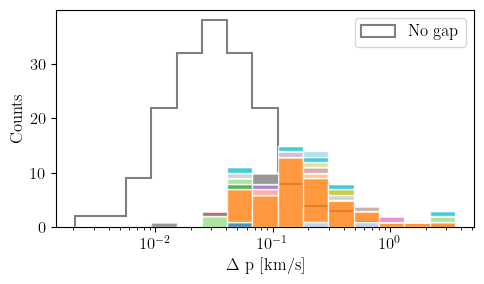

In [15]:
fig,axis=plt.subplots(1,1,figsize=(5,3))
axis.hist(per_suspect,bins=dv_bins,alpha=0.8,stacked=True,color=mycolors,edgecolor="w");
axis.hist(dV_no_gap, bins=dv_bins, histtype='step', color='k', linewidth=1.5, label='No gap',zorder=0,alpha=0.5)
axis.set(**AXIS)
axis.legend()
fig.tight_layout()
# fig.savefig("../paper/impact_geometry_statistics_deltaP.png",dpi=300)

## Scatter the M,V,R 


In [16]:
selected_cols=['impact_parameter', 'v_rel', 'Mass']
criteria = results['gap_flag']==True
withgaps=results[criteria][selected_cols]
withoutgaps=results[~criteria][selected_cols]

In [17]:
# selected_columns = ["v_rel","Mass","impact_parameter","gap_flag","T","tau"]
selected_columns = ["v_rel","Mass","impact_parameter","gap_flag","suspect"]
selected_df=results[selected_columns]
# selected_df.rename(columns={"v_rel":"Relative velocity [km/s]","Mass":"Mass [$M_{\odot}$]","impact_parameter":"Impact parameter [kpc]","gap_flag":"gap_flag",},inplace=True)
selected_df.rename(columns={"v_rel":"Relative velocity [km/s]","Mass":"Mass [$M_{\odot}$]","impact_parameter":"Impact parameter [kpc]","gap_flag":"gap_flag","T":"Time of impact [s kpc / km]","tau":r"$\tau$ [s kpc/km]"},inplace=True)
target_columns=["Relative velocity [km/s]","Mass [$M_{\odot}$]","Impact parameter [kpc]",]

axis_labels = {
    "Relative velocity [km/s]": r"$\delta v$ [km/s]",
    "Mass [$M_{\odot}$]": r"$M$ [$M_{\odot}$]",
    "Impact parameter [kpc]": r"$b$ [kpc]",
}

/tmp/ipykernel_1155086/1018701972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.rename(columns={"v_rel":"Relative velocity [km/s]","Mass":"Mass [$M_{\odot}$]","impact_parameter":"Impact parameter [kpc]","gap_flag":"gap_flag","T":"Time of impact [s kpc / km]","tau":r"$\tau$ [s kpc/km]"},inplace=True)


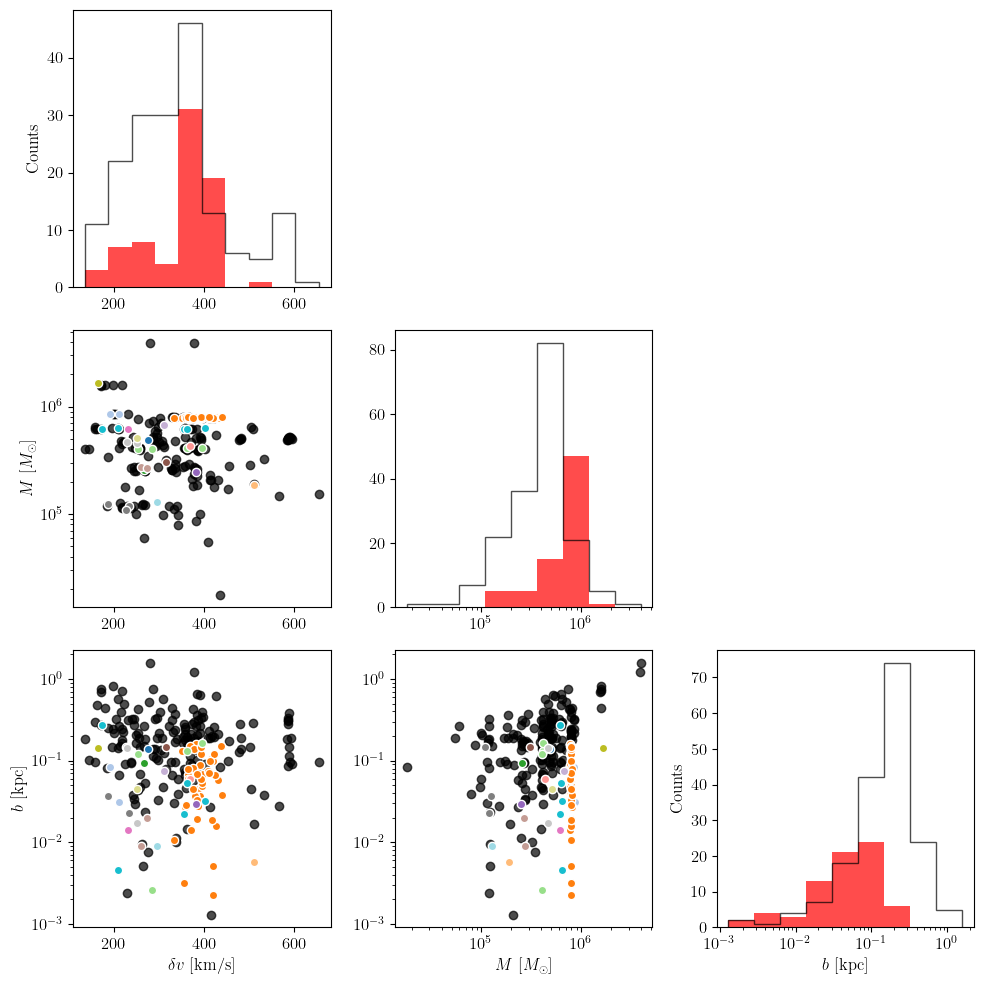

In [18]:
outdir="../paper/impact_geometry_statistics.png"
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

columns=selected_df.columns
log_columns = ['Mass [$M_{\odot}$]', 'Impact parameter [kpc]']  
n = 3


# Create a figure with a gridspec layout
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(n, n, figure=fig)

axes = []
# Plot the pair plot
for i in range(n):
    axes.append([])
    for j in range(i+1):
        ax = fig.add_subplot(gs[i, j])
        axes[i].append(ax)
        
        if i == j:
            # Diagonal: Histogram with log-spaced bins if log scale
            if target_columns[i] in log_columns:
                bins = np.logspace(np.log10(selected_df[target_columns[i]].min()), np.log10(selected_df[target_columns[i]].max()), 10)
                # ax.hist(selected_df[target_columns[i]], bins=bins, color='blue', alpha=0.7)
                ax.hist(selected_df[target_columns[i]][~gap_flag], bins=bins, color='k', alpha=0.7, label='No Gap',histtype='step')
                histcounts,bins,_=ax.hist(selected_df[target_columns[i]][gap_flag], bins=bins, color='red', alpha=0.7, label='Gap')
                ax.set_xscale('log')
            else:
                histcounts,bins,_=ax.hist(selected_df[target_columns[i]][~gap_flag], color='k', alpha=0.7, label='No Gap',histtype='step')
                ax.hist(selected_df[target_columns[i]][gap_flag],bins=bins, color='red', alpha=0.7, label='Gap')
        else:
            # Off-diagonal: Scatter plot
            ax.scatter(selected_df[target_columns[j]][~gap_flag], selected_df[target_columns[i]][~gap_flag], c='k', alpha=0.7, label='No gap',)
            if target_columns[j] in log_columns:  # Replace with your column names
                ax.set_xscale('log')
            if target_columns[i] in log_columns:  # Replace with your column names
                ax.set_yscale('log')
            # ax.scatter(selected_df[target_columns[j]][gap_flag], selected_df[target_columns[i]][gap_flag], c='red', alpha=0.7, label='Gap')
            for key in dictmycolors.keys():
                criteria1 = selected_df['suspect']==key
                criteria2 = selected_df['gap_flag']==True
                criteria = criteria1 & criteria2
                ax.scatter(selected_df[target_columns[j]][criteria], selected_df[target_columns[i]][criteria], color=dictmycolors[key], alpha=1,edgecolor='white',zorder=10)

        

axes[0][0].set_ylabel('Counts')
axes[1][0].set_ylabel(r"$M$ [$M_{\odot}$]")
axes[2][0].set_ylabel(r"$b$ [kpc]")
axes[2][0].set_xlabel(r"$\delta v$ [km/s]")
axes[2][1].set_xlabel(r"$M$ [$M_{\odot}$]")
axes[2][2].set_xlabel(r"$b$ [kpc]")
axes[2][2].set_ylabel(r"Counts")

# Adjust layout
plt.tight_layout()
plt.show()
# fig.savefig(outdir,dpi=300)

#

## Make Fig 3. a table as well

In [19]:
gaps_per_perturber = {}
numgaps = []
for suspect in unique_suspects:
    gaps_per_perturber[suspect] = np.sum(withgap['suspect']==suspect)
    numgaps.append(gaps_per_perturber[suspect])

sorted_indices = np.argsort(-np.array(numgaps))
sorted_suspects = unique_suspects[sorted_indices]
sorted_numgaps = np.array(numgaps)[sorted_indices]
for i in range(len(sorted_suspects)):
    print(f"{sorted_suspects[i]}: {sorted_numgaps[i]}")

NGC2808: 44
NGC7089: 5
NGC5272: 4
NGC6584: 3
NGC6341: 2
NGC6656: 2
NGC104: 2
NGC3201: 1
NGC5634: 1
NGC5286: 1
NGC362: 1
NGC5824: 1
NGC6356: 1
NGC6333: 1
NGC6715: 1
FSR1758: 1
NGC7078: 1
Pal10: 1


In [20]:
len(unique_suspects)

18

In [21]:
# Calculate gaps per perturber
gaps_per_perturber = {}
numgaps = []
for suspect in unique_suspects:
    gaps_per_perturber[suspect] = np.sum(withgap['suspect'] == suspect)
    numgaps.append(gaps_per_perturber[suspect])

# Sort the data
sorted_indices = np.argsort(-np.array(numgaps))
sorted_suspects = unique_suspects[sorted_indices]
sorted_numgaps = np.array(numgaps)[sorted_indices]

# Create LaTeX table string
latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{ll|ll|ll}\n\\hline\n"
for i in range(0, len(sorted_suspects), 3):
    row = ""
    for j in range(3):
        if i + j < len(sorted_suspects):
            row += f"{sorted_suspects[i + j]} & {sorted_numgaps[i + j]} "
            if j < 2:
                row += "& "
    latex_table += row + "\\\\\n"
latex_table += "\\hline\n\\end{tabular}\n\\caption{Gaps per perturber}\n\\label{tab:gaps_per_perturber}\n\\end{table}"

# Print the LaTeX table string
print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{ll|ll|ll}
\hline
NGC2808 & 44 & NGC7089 & 5 & NGC5272 & 4 \\
NGC6584 & 3 & NGC6341 & 2 & NGC6656 & 2 \\
NGC104 & 2 & NGC3201 & 1 & NGC5634 & 1 \\
NGC5286 & 1 & NGC362 & 1 & NGC5824 & 1 \\
NGC6356 & 1 & NGC6333 & 1 & NGC6715 & 1 \\
FSR1758 & 1 & NGC7078 & 1 & Pal10 & 1 \\
\hline
\end{tabular}
\caption{Gaps per perturber}
\label{tab:gaps_per_perturber}
\end{table}


# The reviewer's comment 
Ref : The authors attribute the differences between their results and those of Doke & Hattori (2022) to pre-selection of globular clusters that will interact. It would be useful if this paper made similar cuts to do a direct comparison. Note in Fig 5 that NGC2808 leads to many of the (barely visible) gaps and likely should be discounted. 


## The text

The impact of globular clusters' close interactions with stellar streams has also been the object of another recent paper by \citet{2022ApJ...941..129D}, who concluded that the chance for GD-1 gaps, which have been reported in several works \citep[see, for example, ][]{2019ApJ...880...38B,2018MNRAS.477.1893D,2020AAS...23533607D} to be produced by globular clusters is very low. This result is not necessarily in contradiction with ours since GD-1 has a pericenter which is almost twice that of Palomar~5 \citep[see, for example][]{2019MNRAS.486.2995M}. As discussed in Sect.~\ref{sect:geometry}, the number, $N$, of close encounters that lead to gap creation is anti-correlated with the distance $r$ to the Galactic center. If we naively use the same radial dependence of gaps from Palomar~5 for GD-1 by swapping a pericenter from 6~kpc to 16~kpc, we would reduce the number of gap-favorable impacts by more than a factor of 2. Moreover, we note that \citet{2022ApJ...941..129D} pre-selects the globular clusters that could have experienced a close encounter with the GD-1 stream by selecting only clusters that pass at a distance less than 0.5 kpc from the stream, having a relative velocity smaller than  300 km/s. As shown in our Fig.~\ref{fig:impact_geometry_statistics}, bottom-left panel, in the case of Palomar~5, this choice would lead to excluding most of the encounters favorable to gap creation, which turn out to have relative velocities above 300 km/s. It would be interesting to repeat a similar study as the one made by \citet{2022ApJ...941..129D} for GD-1, imposing no selection on possible candidate clusters.


## The action 
Apply a cut of 300 km and see how many we lose

In [30]:
np.sum(withgaps['impact_parameter'] < 0.5)

np.int64(73)

In [31]:
np.sum(withgaps['v_rel'] < 300)

np.int64(19)